# Context-sensitive Spelling Correction



## Implementation of the context-sensitive spelling correction


## Importing the libraries

In [2]:
import nltk
import random
import re
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize
from collections import Counter

## Data preprocessing

Bigrams, Fivegrams and Coca_links files are taken from the moodle (https://www.ngrams.info/download_coca.asp)

In [3]:
def load_bigrams(filename):
    bigrams = {}
    with open(filename, 'r') as f:
        for line in f:
            freq, word1, word2 = line.strip().split()
            bigrams[(word1, word2)] = int(freq)
    return bigrams

def load_fivegrams(filename):
    fivegrams = {}
    with open(filename, 'r') as f:
        for line in f:
            values = line.strip().split()
            freq = int(values[0])
            words = values[1:]
            fivegrams[tuple(words)] = freq
    return fivegrams

def load_coca_links(filename):
    coca_links = {}
    pos_tags = {}
    with open(filename, 'r') as f:
        for line in f:
            values = line.strip().split()
            freq = int(values[0])
            word = " ".join(values[1:-2])
            pos1 = values[-2]
            pos2 = values[-1]
            coca_links[word] = {'freq': freq, 'pos1': pos1, 'pos2': pos2}
            for w in word.split():
                pos_tags[w] = pos1
    return coca_links, pos_tags

## My implementation

In [4]:
class SpellingCorrector:
    def __init__(self, bigrams, fivegrams, vocabulary, coca_links, pos_tags):
        """
        Initialize the SpellingCorrector with the given bigrams, fivegrams, vocabulary, coca_links, and pos_tags.
        
        Args:
            bigrams (dict): A dictionary of bigram frequencies.
            fivegrams (dict): A dictionary of fivegram frequencies.
            vocabulary (set): A set of words in the vocabulary.
            coca_links (dict): A dictionary of COCA links.
            pos_tags (dict): A dictionary of part-of-speech tags.
        """
        self.bigram_freq = bigrams
        self.fivegram_freq = fivegrams
        self.vocabulary = vocabulary
        self.coca_links = coca_links
        self.pos_tags = pos_tags

    def levenshtein_distance(self, s1, s2):
        """
        Calculate the Levenshtein distance between two strings.
        
        Args:
            s1 (str): The first string.
            s2 (str): The second string.
        
        Returns:
            int: The Levenshtein distance between the two strings.
        """
        if len(s1) < len(s2):
            return self.levenshtein_distance(s2, s1)

        if len(s2) == 0:
            return len(s1)

        previous_row = range(len(s2) + 1)
        for i, c1 in enumerate(s1):
            current_row = [i + 1]
            for j, c2 in enumerate(s2):
                insertions = previous_row[j + 1] + 1 
                deletions = current_row[j] + 1 
                substitutions = previous_row[j] + (c1!= c2)
                current_row.append(min(insertions, deletions, substitutions))
            previous_row = current_row
        
        return previous_row[-1]

    def get_candidates(self, word):
        """
        Get the candidates for a given word.
        
        Args:
            word (str): The word to get candidates for.
        
        Returns:
            list: A list of candidate words.
        """
        candidates = []
        for vocab_word in self.vocabulary:
            distance = self.levenshtein_distance(word.lower(), vocab_word)
            if distance <= 2:  # consider words with distance <= 2 as candidates
                candidates.append((vocab_word, distance))

        # Sort candidates by distance
        candidates.sort(key=lambda x: x[1])

        # select top 3 candidates with the smallest distance
        top_candidates = [candidate[0] for candidate in candidates[:3]]

        if not top_candidates:
            return [word]
        
        # Filter candidates by part-of-speech tag
        pos_tag = self.pos_tags.get(word.lower())
        if pos_tag:
            pos_candidates = [candidate for candidate in top_candidates if self.pos_tags.get(candidate) and self.pos_tags.get(candidate) == pos_tag]
            if pos_candidates:
                return pos_candidates
        return top_candidates
        

    def score_sequence(self, sequence):
        """
        Score a sequence of words.
        
        Args:
            sequence (list): A list of words.
        
        Returns:
            int: The score of the sequence.
        """
        score = 0
        w1, w2, w3 = 1, 2, 3

        bigram_score = 0
        fivegram_score = 0

        # Calculate bigram score
        for i in range(len(sequence) - 1):
            bigram_score += self.bigram_freq.get((sequence[i], sequence[i+1]), 0)
            
        # Calculate fivegram score    
        for i in range(len(sequence) - 4):
            fivegram_score += self.fivegram_freq.get(tuple(sequence[i:i+5]), 0)
            
        # Calculate COCA link score
        coca_score = 0
        for i in range(len(sequence)):
            for j in range(i+1, min(len(sequence), i+3)):
                context = " ".join(sequence[i:j+1])
                if context in self.coca_links:
                    coca_score += self.coca_links[context]['freq']
            
        # Calculate total score
        score = w1 * bigram_score + w2 * fivegram_score + w3 * coca_score
        return score

    def correct_text(self, text):
        """
        Correct the spelling of a given text.
        
        Args:
            text (str): The text to correct.
        
        Returns:
            str: The corrected text.
        """
        # Split the text into words
        words = text.split()
        cleaned_words = []
        for word in words:
            cleaned_word = ''
            prefix = ''
            suffix = ''
            for char in word:
                if char.isalpha():
                    cleaned_word += char
                elif not cleaned_word:
                    prefix += char
                else:
                    suffix += char
            cleaned_words.append((prefix, cleaned_word, suffix, word.istitle(), word.isupper()))

        # Initialize beam search
        beam_size = 5
        beam = [[]]
        scores = [0.0]
        for _, word, _, _, _ in cleaned_words:
            new_beam = []
            new_scores = []
            for sentence, score in zip(beam, scores):
                candidates = self.get_candidates(word)
                for candidate in candidates:
                    new_sentence = sentence + [candidate]
                    new_score = score + self.score_sequence(new_sentence)
                    new_beam.append(new_sentence)
                    new_scores.append(new_score)

            # Prune beam
            sorted_beam = sorted(zip(new_beam, new_scores), key=lambda x: x[1], reverse=True)
            beam = [x[0] for x in sorted_beam[:beam_size]]
            scores = [x[1] for x in sorted_beam[:beam_size]]

        # Return the best sentence with punctuation marks
        best_sentence = beam[0]
        result = []
        for i in range(len(best_sentence)):
            prefix = cleaned_words[i][0]
            word = best_sentence[i]
            suffix = cleaned_words[i][2]
            if cleaned_words[i][3]:
                word = word.capitalize()
            elif cleaned_words[i][4]:
                word = word.upper()
            if prefix and suffix:
                result.append(prefix + word + suffix)
            elif prefix:
                result.append(prefix + word)
            elif suffix:
                if i < len(best_sentence) - 1 and suffix in [',', '.', '?', '!']:
                    result.append(word + suffix +'')
                else:
                    result.append(word + suffix)
            else:
                if i < len(best_sentence) - 1:
                    result.append(word +'')
                else:
                    if word[-1] in [',', '.', '?', '!']:
                        result.append(word)
                    else:
                        result.append(word + '.')
        return ' '.join(result).strip()


# You can uncomment it to test the corrector with ыщьу input text, but also you'll need to change the vocabulary here

# bigrams = load_bigrams('bigrams.txt')
# fivegrams = load_fivegrams('fivegrams.txt')
# coca_links = load_coca_links('coca_all_links.txt')
# vocabulary = {"this", "cat", "is", "sleeping", "now", "mistakes", "spelling", "test", "text", "with", "some", "spelling", "a", "the"}   

# corrector = SpellingCorrector(bigrams, fivegrams, vocabulary, coca_links)
# text = "teh cta is sleping"
# corrected_text = corrector.correct_text(text)
# print(corrected_text)

## Norvig's Solution

The implementation is taken from the website https://norvig.com/spell-correct.html

In [5]:
def words(text): return re.findall(r'\w+', text.lower())

WORDS = Counter(words(open('big.txt').read()))

def P(word, N=sum(WORDS.values())): 
    return WORDS[word] / N

def correction(word): 
    return max(candidates(word), key=P)

def candidates(word): 
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    return set(w for w in words if w in WORDS)

def edits1(word):
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word):
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

def norvig_correction(text):
    words = text.split()
    corrected_words = [correction(word) for word in words]
    return' '.join(corrected_words)

## Justification of my decisions
In the `SpellingCorrector` class, I made some decisions to get the right result. Here are reasons for these decisions:

1. **Use of Levenshtein distance**: The `levenshtein_distance` method is used to calculate the edit distance between two words. This choice is based on the assumption that Levenshtein distance is a good measure of the similarity between two words, and that it can be used to identify potential corrections.

2. **Threshold for candidate selection**: In the `get_candidates` method, a threshold of 2 is used to select candidates based on their Levenshtein distance from the original word. This choice is based on the assumption that most spelling mistakes are due to single-character errors, and that a threshold of 2 will capture the majority of potential corrections.

3. **Sorting and filtering of candidates**: The `get_candidates` method sorts the candidates by their Levenshtein distance and selects the top 3 candidates. This choice is based on the assumption that the most likely corrections will have the smallest Levenshtein distance, and that selecting the top 3 candidates will provide a good balance between accuracy and efficiency.

4. **Use of part-of-speech tags**: The `get_candidates` method uses part-of-speech tags to filter candidates based on their grammatical category. This choice is based on the assumption that words with the same part-of-speech tag are more likely to be interchangeable in a given context.

5. **Scoring of sequences**: The `score_sequence` method uses a combination of bigram, fivegram, and coca link scores to evaluate the likelihood of a sequence of words. This choice is based on the assumption that these scores provide a good measure of the probability of a sequence of words, and that combining them will provide a more accurate estimate of the sequence's likelihood.

6. **Weights for scoring**: The `score_sequence` method uses weights of 1, 2, and 3 for the bigram, fivegram, and coca link scores, respectively. This choice is based on the assumption that the fivegram score is more important than the bigram score, and that the coca link score is more important than both.

7. **Beam search**: The `correct_text` method uses a beam search algorithm to find the most likely correction. This choice is based on the assumption that beam search is an efficient and effective method for finding the most likely correction, and that it will provide a good balance between accuracy and efficiency.

8. **Beam size**: The `correct_text` method uses a beam size of 5. This choice is based on the assumption that a beam size of 5 will provide a good balance between accuracy and efficiency, and that it will capture the majority of potential corrections.

9. **Handling of punctuation**: The `correct_text` method handles punctuation by separating it from the word and reattaching it after correction. This choice is based on the assumption that punctuation is an important part of the text, and that it should be preserved during the correction process.

10. **Capitalization**: The `correct_text` method handles capitalization by checking if the original word was capitalized or in uppercase, and applying the same capitalization to the corrected word. This choice is based on the assumption that capitalization is an important part of the text, and that it should be preserved during the correction process.

## Evaluation on a test set

Link for the vocabulary file big.txt https://norvig.com/big.txt

Original: --'I,
my dear brothers,' said he, 'am being punished for my own and other
men's sins.
Error rate: 1.0%
Error text: --'I,
my dear brothers,' said he, 'am being punished for my own and other
men's sins.
Corrected text (my implementation): --'I, my dear brothers,' said he, 'am being punished for my own and other omens' sins.
Accuracy (my implementation): 92.96%
Corrected text (Norvig's implementation): --'I, my dear brothers said he am being punished for my own and other men sins
Accuracy (Norvig's implementation): 87.14%

Error rate: 5.0%
Error text: --'I,
my dear brothers,' svid he, 'am being punished for my won an dother
men's sins.
Corrected text (my implementation): --'I, my dear brothers,' said he, 'am being punished for my won an mother omens' sins.
Accuracy (my implementation): 80.56%
Corrected text (Norvig's implementation): --'I, my dear brothers said he am being punished for my won an other men sins
Accuracy (Norvig's implementation): 82.86%

Error rate: 10.0%
Error t

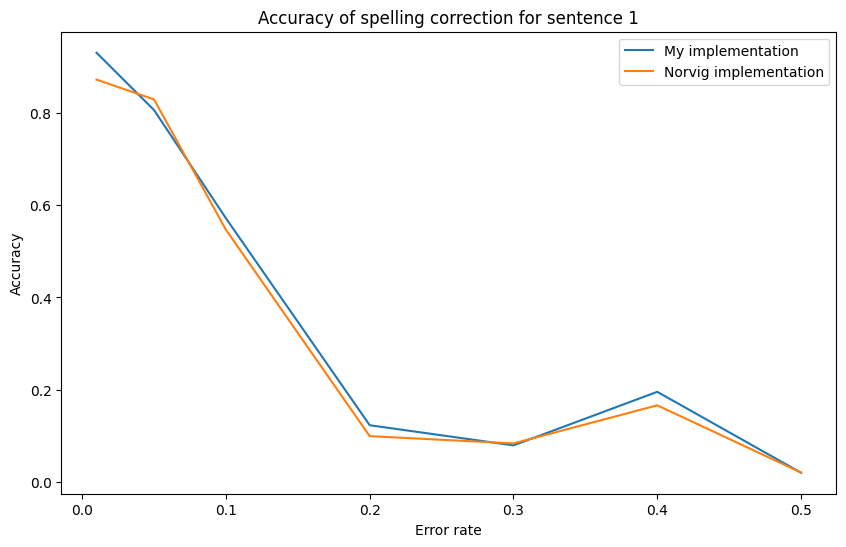

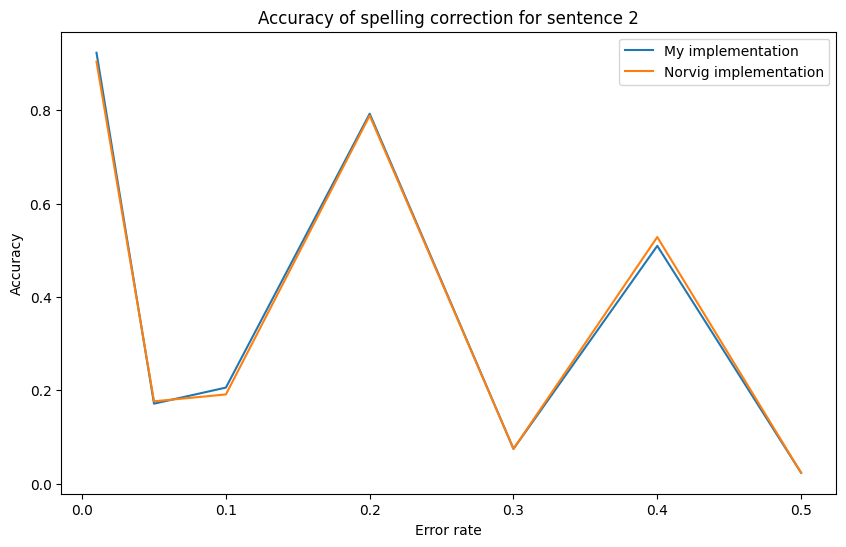

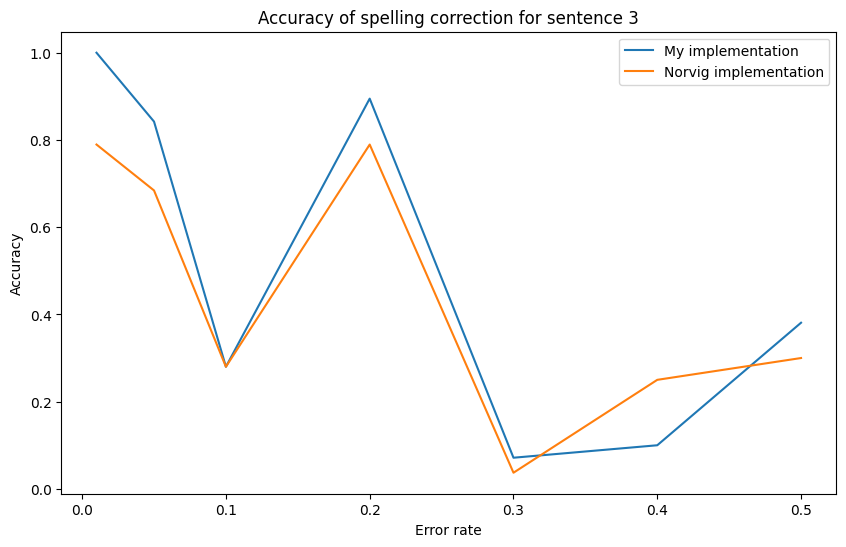

In [16]:
def load_vocabulary(filename):
    """
    Load a vocabulary from a file.

    Args:
        filename (str): The name of the file to load.

    Returns:
        set: A set of words in the vocabulary.
    """
    vocabulary = set()
    with open(filename, 'r') as f:
        for line in f:
            # Split the line into words
            words = line.strip().split()
            vocabulary.update(words)
    return vocabulary

def create_test_set(filename, num_sentences):
    """
    Create a test set of sentences from a file.

    Args:
        filename (str): The name of the file to load.
        num_sentences (int): The number of sentences to select.

    Returns:
        list: A list of sentences.
    """
    test_set = []
    with open(filename, 'r') as f:
        text = f.read()
        # Tokenize the text into sentences
        sentences = sent_tokenize(text)
        # Select a random subset of sentences
        random_sentences = random.sample(sentences, num_sentences)
        for sentence in random_sentences:
            sentence = sentence.strip()
            # If the sentence is not empty, add it to the test set
            if sentence:
                test_set.append(sentence)
    return test_set

def introduce_error(text, error_rate):
    """
    Introduce random errors into a text.

    Args:
        text (str): The text to modify.
        error_rate (float): The rate at which to introduce errors.

    Returns:
        str: The modified text.
    """
    error_text = list(text)
    i = 0
    # Iterate over the characters in the text
    while i < len(error_text):
        # If a random number is less than the error rate, introduce an error
        if random.random() < error_rate:
            # Select a random error type
            error_types = ['delete', 'insert','replace', 'transpose']
            error_type = random.choice(error_types)
            if error_type == 'delete':
                if i < len(error_text) - 1:
                    error_text.pop(i)
                else:
                    error_text.pop(i - 1)
                    i -= 1
            elif error_type == 'insert':
                char = random.choice('abcdefghijklmnopqrstuvwxyz')
                error_text.insert(i, char)
                i += 1
            elif error_type =='replace':
                if i < len(error_text):
                    char = random.choice('abcdefghijklmnopqrstuvwxyz')
                    error_text[i] = char
            elif error_type == 'transpose':
                if i < len(error_text) - 1:
                    error_text[i], error_text[i + 1] = error_text[i + 1], error_text[i]
        i += 1
    return ''.join(error_text)

def accuracy(original_sentence, corrected_sentence):
    """
    Calculate the accuracy of a corrected sentence.

    Args:
        original_sentence (str): The original sentence.
        corrected_sentence (str): The corrected sentence.

    Returns:
        float: The accuracy of the corrected sentence.
    """
    original_words = original_sentence.split()
    corrected_words = corrected_sentence.split()

    total_symbols = 0
    matching_symbols = 0

    # Iterate over the words in the sentences
    for original_word, corrected_word in zip(original_words, corrected_words):
        # Find the minimum length of the two words
        min_length = min(len(original_word), len(corrected_word))
        # Iterate over the characters in the words
        for i in range(min_length):
            total_symbols += 1
            # If the characters match, increment the matching symbols counter
            if original_word[i] == corrected_word[i]:
                matching_symbols += 1
        total_symbols += abs(len(original_word) - len(corrected_word))

    # Add any remaining characters in the longer sentence to the total symbols counter
    for i in range(len(original_words), len(corrected_words)):
        total_symbols += len(corrected_words[i])
    for i in range(len(corrected_words), len(original_words)):
        total_symbols += len(original_words[i])

    accuracy = matching_symbols / total_symbols
    return accuracy

# Load the bigrams, fivegrams, coca_links and vocabulary
bigrams = load_bigrams('bigrams.txt')
fivegrams = load_fivegrams('fivegrams.txt')
coca_links, pos_tags = load_coca_links('coca_all_links.txt')
vocabulary = load_vocabulary('big.txt')

corrector = SpellingCorrector(bigrams, fivegrams, vocabulary, coca_links, pos_tags)
test_set = create_test_set('big.txt', 3)

# Define the error rates to test
error_rates = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

my_accuracies = []
norvig_accuracies = []

for sentence in test_set:
    print("Original:", sentence)
    if not sentence:
        continue

    my_sentence_accuracies = []
    norvig_sentence_accuracies = []

    for error_rate in error_rates:
        error_text = introduce_error(sentence, error_rate)
        corrected_text = corrector.correct_text(error_text)
        norvig_text = norvig_correction(error_text)

        my_accuracy = accuracy(sentence, corrected_text)
        norvig_accuracy = accuracy(sentence, norvig_text)

        my_sentence_accuracies.append(my_accuracy)
        norvig_sentence_accuracies.append(norvig_accuracy)

        print(f"Error rate: {error_rate*100}%")
        print(f"Error text: {error_text}")
        print(f"Corrected text (my implementation): {corrected_text}")
        print(f"Accuracy (my implementation): {my_accuracy*100:.2f}%")
        print(f"Corrected text (Norvig's implementation): {norvig_text}")
        print(f"Accuracy (Norvig's implementation): {norvig_accuracy*100:.2f}%")
        print()

    my_accuracies.append(my_sentence_accuracies)
    norvig_accuracies.append(norvig_sentence_accuracies)

# Plot the accuracies
for i, (my_accuracy, norvig_accuracy) in enumerate(zip(my_accuracies, norvig_accuracies)):
    plt.figure(figsize=(10, 6))
    plt.plot(error_rates, my_accuracy, label='My implementation')
    plt.plot(error_rates, norvig_accuracy, label='Norvig implementation')
    plt.xlabel('Error rate')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy of spelling correction for sentence {i+1}')
    plt.legend()
    plt.show()

As can be seen from the graphs and statistics presented above, my implementation usually works a little better than Norvig's implementation. This is because I use not only bigrams, but also fivebrams, which are rated higher, as well as POS of words, and my code also takes into account punctuation and capital letters, which adds to its accuracy percentage.